In [1]:
# Imports
import os
import random
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision import models
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import functional as TF
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingLR
# Step 1: Mount Google Drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
# Step 2: Define paths (edit these if needed)
zip_path = "/content/drive/MyDrive/dataset_V6.zip"  # <-- change this if your file is in a folder
extract_dir = "/content/dataset_V6"

# Step 3: Unzip the dataset
import zipfile

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted dataset to: {extract_dir}")



# Step 4 (Optional): Copy the CSV if it's also on Drive
# If your CSV is in MyDrive, adjust the path accordingly

csv_drive_path = "/content/drive/MyDrive/dataset_V6.csv"
csv_colab_path = "/content/dataset_V6.csv"

!cp "{csv_drive_path}" "{csv_colab_path}"

print(f"✅ CSV copied to: {csv_colab_path}")




Mounted at /content/drive
✅ Extracted dataset to: /content/dataset_V6
✅ CSV copied to: /content/dataset_V6.csv


In [2]:
# class PadToSquareWithMean:
#     def __call__(self, image):
#         w, h = image.size
#         max_dim = max(w, h)
#         pad_left = (max_dim - w) // 2
#         pad_top = (max_dim - h) // 2
#         pad_right = max_dim - w - pad_left
#         pad_bottom = max_dim - h - pad_top

#         # Compute true mean color
#         np_img = np.array(image)
#         mean_color = tuple(np_img.reshape(-1, 3).mean(axis=0).astype(np.uint8))

#         return TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom),
#                       fill=mean_color, padding_mode='constant')

CSV_PATH = "dataset_V6.csv"
IMAGE_DIR = "/content/dataset_V6/dataset_V6"

# # ===== Base + Augmentation Transforms =====
# base_transform = transforms.Compose([
#     PadToSquareWithMean(),
#     transforms.Resize((300, 300)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])  # standard ImageNet normalization
# ])

# aug_transform = transforms.Compose([
#     PadToSquareWithMean(),
#     transforms.Resize((300, 300)),
#     transforms.RandomRotation(25),
#     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
#     transforms.RandomAffine(15, translate=(0.1,0.1)),
#     # transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.transforms import functional as TF

# ---------- Utils ----------
def _mean_rgb(image: Image.Image):
    arr = np.array(image.convert("RGB"))
    return tuple(arr.reshape(-1, 3).mean(axis=0).astype(np.uint8).tolist())

class PadToSquareWithMean:
    def __call__(self, image: Image.Image):
        w, h = image.size
        max_dim = max(w, h)
        pad_left  = (max_dim - w) // 2
        pad_top   = (max_dim - h) // 2
        pad_right = max_dim - w - pad_left
        pad_bottom= max_dim - h - pad_top
        mean_color = _mean_rgb(image)
        return TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom),
                      fill=mean_color, padding_mode='constant')

class RotateWithMeanFill:
    def __init__(self, degrees=12):
        self.degrees = degrees
    def __call__(self, image: Image.Image):
        angle = transforms.RandomRotation.get_params([-self.degrees, self.degrees])
        mean_color = _mean_rgb(image)
        # expand=False keeps size; corners are filled with mean_color
        return TF.rotate(image, angle=angle, expand=False, fill=mean_color)

class AffineWithMeanFill:
    """
    Mild translation/scale/shear with mean-color fill.
    Set degrees if you want an extra tiny shear rotation; otherwise keep 0.
    """
    def __init__(self, degrees=0, translate=(0.08, 0.08), scale=(0.95, 1.05), shear=(-5, 5)):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.shear = shear

    def __call__(self, image: Image.Image):
        # sample params the same way torchvision does
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            degrees=(-self.degrees, self.degrees),
            translate=self.translate,
            scale_ranges=self.scale,
            shears=self.shear,
            img_size=image.size
        )
        mean_color = _mean_rgb(image)
        return TF.affine(
            image,
            angle=angle,
            translate=translations,
            scale=scale,
            shear=shear,
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=mean_color
        )

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# ---------- Base (no aug) ----------
base_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ---------- Augmented (train) ----------
aug_transform = transforms.Compose([
    PadToSquareWithMean(),
    transforms.Resize((260, 260)),

    # Geometry (keep mild/realistic for microscope images)
    RotateWithMeanFill(degrees=12),              # ~±12°
    transforms.RandomHorizontalFlip(p=0.3),      # set to 0 if orientation-critical
    transforms.RandomVerticalFlip(p=0.1),        # consider disabling if S/I matters
    AffineWithMeanFill(
        degrees=0,                               # keep 0 unless you want extra tiny rotation
        translate=(0.10, 0.10),
        scale=(0.95, 1.05),
        shear=(-4, 4)
    ),

    # Photometric
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.10)
    ], p=0.6),

    # Light blur (focus drift)
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.2))
    ], p=0.3),

    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),

    # Occlusion (simulates tools, glare, bubbles)
    transforms.RandomErasing(
        p=0.25,
        scale=(0.02, 0.08),
        ratio=(0.3, 3.3),
        value='random'
    ),
])

# ========== Dataset ==========
class CataractDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"low": 0, "moderate": 1, "high": 2, "mature": 3, "poor dilation": 4}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"] + ".jpg")
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Missing image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.data))

        label = self.label_map[row["label"].lower()]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# ========== Load and Prepare CSV ==========
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive label column from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"


# Keep only valid rows
df = df[df["label"].notna()]
df = df[["filename", "label"]]
# ========= Balance Function =========
def balance_dataset(df, image_dir, target_per_class =800):
    datasets = []
    class_counts = df['label'].value_counts().to_dict()
    augmented_summary = {}

    for label, count in class_counts.items():
        class_df = df[df['label'] == label]

        # Keep all original samples
        datasets.append(CataractDataset(class_df, image_dir, transform=base_transform))

        # Only add augmentation if class is below target
        if count < target_per_class:
            needed = target_per_class - count
            aug_rows = class_df.sample(needed, replace=True, random_state=42)
            datasets.append(CataractDataset(aug_rows, image_dir, transform=aug_transform))
            augmented_summary[label] = needed
        else:
            augmented_summary[label] = 0  # nothing added

    balanced_dataset = ConcatDataset(datasets)

    # Print summary
    print("\n=== Balancing Summary (No Downsampling) ===")
    for label, count in class_counts.items():
        added = augmented_summary[label]
        final_count = count + added
        print(f"{label:15s} | Original: {count:4d} | Added: {added:4d} | Final: {final_count:4d}")
    print(f"\nTotal balanced dataset size: {len(balanced_dataset)}")

    return balanced_dataset


df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df.rename(columns={"Frame Name": "filename"}, inplace=True)

# Derive labels from binary indicators
df["label"] = None
df.loc[df["Low Nuclear Density"] == 1.0, "label"] = "low"
df.loc[df["Moderate Nuclear Density"] == 1.0, "label"] = "moderate"
df.loc[df["High Nuclear Density"] == 1.0, "label"] = "high"
df.loc[df["Mature"] == 1.0, "label"] = "mature"
df.loc[df["Poor Dilation"] == 1.0, "label"] = "poor dilation"

df = df[df["label"].notna()]
df = df[["filename", "label"]]

# ========= Split Dataset =========
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ========= Create Datasets =========
train_dataset = balance_dataset(train_df, IMAGE_DIR, target_per_class=800)
val_dataset = CataractDataset(val_df, IMAGE_DIR, transform=base_transform)
test_dataset = CataractDataset(test_df, IMAGE_DIR, transform=base_transform)

# ========= Create DataLoaders =========
BATCH_SIZE = 64
num_cpu = multiprocessing.cpu_count()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_cpu//2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cpu//2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_cpu//2, pin_memory=True)



Train: 1404, Val: 301, Test: 301

=== Balancing Summary (No Downsampling) ===
mature          | Original:  367 | Added:  433 | Final:  800
low             | Original:  323 | Added:  477 | Final:  800
high            | Original:  298 | Added:  502 | Final:  800
poor dilation   | Original:  251 | Added:  549 | Final:  800
moderate        | Original:  165 | Added:  635 | Final:  800

Total balanced dataset size: 4000


In [3]:
def efficientnet_b3(num_classes=5, pretrained=True, phase="warmup"):
    """
    EfficientNet-B3 with progressive fine-tuning.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    pretrained : bool
        Whether to load ImageNet pretrained weights.
    phase : str
        "warmup"   → train only classifier
        "partial"  → unfreeze last 2 feature blocks + classifier
        "full"     → train all layers

    Returns
    -------
    model : nn.Module
    """
    weights = models.EfficientNet_B3_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b3(weights=weights)

    # Replace final classifier
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, num_classes)

    # Freeze all parameters initially
    for name, param in model.named_parameters():
        param.requires_grad = False

        if phase == "warmup" and name.startswith("classifier"):
            param.requires_grad = True

        # EfficientNet-B3 has 8 feature blocks (features.0 through features.8)
        elif phase == "partial" and name.startswith(("features.7", "features.8", "classifier")):
            param.requires_grad = True

        elif phase == "full":
            param.requires_grad = True

    return model


In [4]:
def efficientnet_b2(num_classes=5, pretrained=True, phase="warmup"):
    """
    EfficientNet-B2 with progressive fine-tuning.

    Parameters
    ----------
    num_classes : int
        Number of output classes.
    pretrained : bool
        Whether to load ImageNet pretrained weights.
    phase : str
        "warmup"   → train only classifier
        "partial"  → unfreeze last 2 feature blocks + classifier
        "full"     → train all layers

    Returns
    -------
    model : nn.Module
    """
    weights = models.EfficientNet_B2_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b2(weights=weights)

    # Replace final classifier
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, num_classes)

    # Set requires_grad depending on phase
    for name, param in model.named_parameters():
        param.requires_grad = False  # freeze everything first

        if phase == "warmup" and name.startswith("classifier"):
            param.requires_grad = True

        elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
            param.requires_grad = True

        elif phase == "full":
            param.requires_grad = True

    return model


**B2**


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ===== EfficientNet with Progressive Phases =====
# def efficientnet_b2(num_classes=5, pretrained=True, phase="warmup"):
#     weights = models.EfficientNet_B2_Weights.DEFAULT if pretrained else None
#     model = models.efficientnet_b2(weights=weights)

#     # Replace classifier
#     in_feats = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(in_feats, num_classes)

#     # Freeze/unfreeze according to phase
#     for name, param in model.named_parameters():
#         param.requires_grad = False

#         if phase == "warmup" and name.startswith("classifier"):
#             param.requires_grad = True
#         elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
#             param.requires_grad = True
#         elif phase == "full":
#             param.requires_grad = True

#     return model

# ===== Training Utilities =====
def train_one_epoch(model, loader, optimizer, criterion, epoch, total_epochs, phase_name):
    model.train()
    running_loss, preds_all, labels_all = 0.0, [], []
    total_steps = len(loader)

    for step, (images, labels) in enumerate(loader, 1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds_all.extend(outputs.argmax(1).cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

        # Print per-step loss
        if (step+1) % 5 == 0:
          print(f"[{phase_name} | Epoch {epoch}/{total_epochs} | Step {step}/{total_steps}] "
              f"Step Loss: {loss.item():.4f}")


    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, preds_all, labels_all, probs_all = 0.0, [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds_all.extend(outputs.argmax(1).cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            probs_all.extend(F.softmax(outputs, dim=1).cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all, probs_all


def progressive_training(train_loader, val_loader, num_classes=5):
    phases = [
        {"name": "warmup", "epochs": 10, "lr": 1e-3},
        {"name": "partial", "epochs": 15, "lr": 5e-5},
        {"name": "full", "epochs": 20, "lr": 5e-6},
    ]

    criterion = nn.CrossEntropyLoss()
    prev_phase = None

    all_train_losses = []
    all_val_losses = []

    for phase in phases:
        print(f"\n=== Phase: {phase['name']} ===")

        if prev_phase is None:
            # model = efficientnet_b2(num_classes=num_classes, phase="warmup").to(device)
            model = efficientnet_b3(num_classes=num_classes, phase="warmup").to(device)
            # model = EfficientNetB2WithDropout(num_classes=num_classes, phase="warmup").to(device)

        else:
            # model = efficientnet_b2(num_classes=num_classes, phase=phase["name"]).to(device)
            # model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
            model = efficientnet_b3(num_classes=num_classes, phase=phase["name"]).to(device)
            model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
            # model = EfficientNetB2WithDropout(num_classes=num_classes, phase=phase["name"]).to(device)
            # model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
        # optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
        #                        lr=phase["lr"], weight_decay=1e-4)

        optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=phase["lr"],              # keep the LR from your phase config
        weight_decay=1e-4            # same weight decay you used before
        )

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

        # # T_max is the number of epochs over which to anneal from initial lr → eta_min
        # scheduler = CosineAnnealingLR(
        #     optimizer,
        #     T_max=phase["epochs"],
        #     eta_min=1e-6,    # floor learning rate
        #     last_epoch=-1    # start from scratch each phase
        # )

        best_val_loss = np.inf
        patience, patience_counter = 3, 0

        for epoch in range(1, phase["epochs"] + 1):
            train_loss, train_acc, train_f1, y_train, y_pred_train = train_one_epoch(
                model, train_loader, optimizer, criterion, epoch, phase["epochs"], phase["name"])
            val_loss, val_acc, val_f1, y_val, y_pred_val, y_proba_val = evaluate(
                model, val_loader, criterion)

            # # update LR scheduler
            # if isinstance(scheduler, ReduceLROnPlateau):
            #     scheduler.step(val_loss)
            # else:
            #     scheduler.step()

            # scheduler.step()

            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)

            # End of epoch summary
            print(f"Epoch [{epoch}/{phase['epochs']}], "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f"best_model_{phase['name']}.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        # ---- After each phase: Per-class metrics ----
        print(f"\n=== Detailed Metrics for Phase: {phase['name']} ===")
        print(classification_report(y_val, y_pred_val, target_names=["low", "moderate", "high", "mature", "poor dilation"]))

        cm = confusion_matrix(y_val, y_pred_val)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=["low", "moderate", "high", "mature", "poor dilation"])
        disp.plot(cmap="Blues")
        plt.show()

        # ROC-AUC (One-vs-Rest)
        try:
            roc_auc = roc_auc_score(y_val, y_proba_val, multi_class="ovr")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError:
            print("ROC-AUC could not be computed (need probabilities for all classes).")

        prev_phase = phase["name"]


    plt.figure(figsize=(8,6))
    plt.plot(all_train_losses, label="Train Loss")
    plt.plot(all_val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nTraining complete. Best models for each phase saved.")
    return model



=== Phase: warmup ===


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 199MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[warmup | Epoch 1/10 | Step 4/63] Step Loss: 1.6084
[warmup | Epoch 1/10 | Step 9/63] Step Loss: 1.5448
[warmup | Epoch 1/10 | Step 14/63] Step Loss: 1.5209
[warmup | Epoch 1/10 | Step 19/63] Step Loss: 1.4779
[warmup | Epoch 1/10 | Step 24/63] Step Loss: 1.4301
[warmup | Epoch 1/10 | Step 29/63] Step Loss: 1.4803
[warmup | Epoch 1/10 | Step 34/63] Step Loss: 1.4153
[warmup | Epoch 1/10 | Step 39/63] Step Loss: 1.4237
[warmup | Epoch 1/10 | Step 44/63] Step Loss: 1.3002
[warmup | Epoch 1/10 | Step 49/63] Step Loss: 1.4043
[warmup | Epoch 1/10 | Step 54/63] Step Loss: 1.3893
[warmup | Epoch 1/10 | Step 59/63] Step Loss: 1.3715
Epoch [1/10], Train Loss: 1.4289, Acc: 0.4427, F1: 0.4403 | Val Loss: 1.2807, Acc: 0.5648, F1: 0.5632
[warmup | Epoch 2/10 | Step 4/63] Step Loss: 1.2726
[warmup | Epoch 2/10 | Step 9/63] Step Loss: 1.2719
[warmup | Epoch 2/10 | Step 14/63] Step Loss: 1.2524
[warmup | Epoch 2/10 | Step 19/63] Step Loss: 1.2225
[warmup | Epoch 2/10 | Step 24/63] Step Loss: 1.2719
[

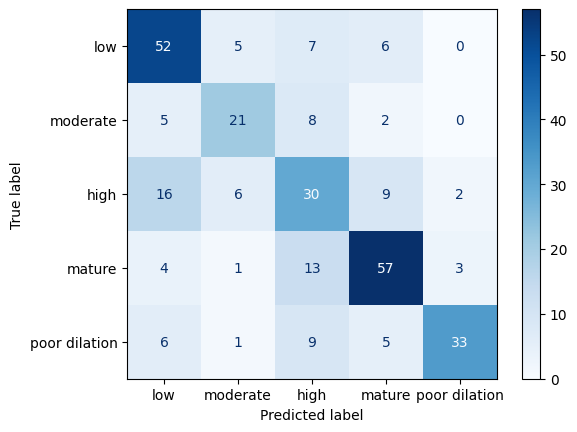

ROC-AUC: 0.8788

=== Phase: partial ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[partial | Epoch 1/15 | Step 4/63] Step Loss: 0.7641
[partial | Epoch 1/15 | Step 9/63] Step Loss: 0.8040
[partial | Epoch 1/15 | Step 14/63] Step Loss: 0.8050
[partial | Epoch 1/15 | Step 19/63] Step Loss: 0.7270
[partial | Epoch 1/15 | Step 24/63] Step Loss: 0.9301
[partial | Epoch 1/15 | Step 29/63] Step Loss: 0.8102
[partial | Epoch 1/15 | Step 34/63] Step Loss: 0.9034
[partial | Epoch 1/15 | Step 39/63] Step Loss: 0.8048
[partial | Epoch 1/15 | Step 44/63] Step Loss: 0.6646
[partial | Epoch 1/15 | Step 49/63] Step Loss: 0.7194


Exception in thread Thread-25 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/resource_s

KeyboardInterrupt: 

In [6]:
model = progressive_training(train_loader, val_loader, num_classes=5)

**B3**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ===== EfficientNet with Progressive Phases =====
# def efficientnet_b2(num_classes=5, pretrained=True, phase="warmup"):
#     weights = models.EfficientNet_B2_Weights.DEFAULT if pretrained else None
#     model = models.efficientnet_b2(weights=weights)

#     # Replace classifier
#     in_feats = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(in_feats, num_classes)

#     # Freeze/unfreeze according to phase
#     for name, param in model.named_parameters():
#         param.requires_grad = False

#         if phase == "warmup" and name.startswith("classifier"):
#             param.requires_grad = True
#         elif phase == "partial" and name.startswith(("features.6", "features.7", "classifier")):
#             param.requires_grad = True
#         elif phase == "full":
#             param.requires_grad = True

#     return model

# ===== Training Utilities =====
def train_one_epoch(model, loader, optimizer, criterion, epoch, total_epochs, phase_name):
    model.train()
    running_loss, preds_all, labels_all = 0.0, [], []
    total_steps = len(loader)

    for step, (images, labels) in enumerate(loader, 1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds_all.extend(outputs.argmax(1).cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

        # Print per-step loss
        if (step+1) % 5 == 0:
          print(f"[{phase_name} | Epoch {epoch}/{total_epochs} | Step {step}/{total_steps}] "
              f"Step Loss: {loss.item():.4f}")


    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, preds_all, labels_all, probs_all = 0.0, [], [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds_all.extend(outputs.argmax(1).cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            probs_all.extend(F.softmax(outputs, dim=1).cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    f1 = f1_score(labels_all, preds_all, average="weighted")
    return running_loss / len(loader.dataset), acc, f1, labels_all, preds_all, probs_all


def progressive_training(train_loader, val_loader, num_classes=5):
    phases = [
        {"name": "warmup", "epochs": 10, "lr": 1e-3},
        {"name": "partial", "epochs": 15, "lr": 5e-5},
        {"name": "full", "epochs": 20, "lr": 5e-6},
    ]

    criterion = nn.CrossEntropyLoss()
    prev_phase = None

    all_train_losses = []
    all_val_losses = []

    for phase in phases:
        print(f"\n=== Phase: {phase['name']} ===")

        if prev_phase is None:
            model = efficientnet_b2(num_classes=num_classes, phase="warmup").to(device)
            # model = efficientnet_b3(num_classes=num_classes, phase="warmup").to(device)
            # model = EfficientNetB2WithDropout(num_classes=num_classes, phase="warmup").to(device)

        else:
            model = efficientnet_b2(num_classes=num_classes, phase=phase["name"]).to(device)
            model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
            # model = efficientnet_b3(num_classes=num_classes, phase=phase["name"]).to(device)
            # model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
            # model = EfficientNetB2WithDropout(num_classes=num_classes, phase=phase["name"]).to(device)
            # model.load_state_dict(torch.load(f"best_model_{prev_phase}.pth"))
        # optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
        #                        lr=phase["lr"], weight_decay=1e-4)

        optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=phase["lr"],              # keep the LR from your phase config
        weight_decay=1e-4            # same weight decay you used before
        )

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

        # # T_max is the number of epochs over which to anneal from initial lr → eta_min
        # scheduler = CosineAnnealingLR(
        #     optimizer,
        #     T_max=phase["epochs"],
        #     eta_min=1e-6,    # floor learning rate
        #     last_epoch=-1    # start from scratch each phase
        # )

        best_val_loss = np.inf
        patience, patience_counter = 3, 0

        for epoch in range(1, phase["epochs"] + 1):
            train_loss, train_acc, train_f1, y_train, y_pred_train = train_one_epoch(
                model, train_loader, optimizer, criterion, epoch, phase["epochs"], phase["name"])
            val_loss, val_acc, val_f1, y_val, y_pred_val, y_proba_val = evaluate(
                model, val_loader, criterion)

            # # update LR scheduler
            # if isinstance(scheduler, ReduceLROnPlateau):
            #     scheduler.step(val_loss)
            # else:
            #     scheduler.step()

            # scheduler.step()

            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)

            # End of epoch summary
            print(f"Epoch [{epoch}/{phase['epochs']}], "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f"best_model_{phase['name']}.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break

        # ---- After each phase: Per-class metrics ----
        print(f"\n=== Detailed Metrics for Phase: {phase['name']} ===")
        print(classification_report(y_val, y_pred_val, target_names=["low", "moderate", "high", "mature", "poor dilation"]))

        cm = confusion_matrix(y_val, y_pred_val)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=["low", "moderate", "high", "mature", "poor dilation"])
        disp.plot(cmap="Blues")
        plt.show()

        # ROC-AUC (One-vs-Rest)
        try:
            roc_auc = roc_auc_score(y_val, y_proba_val, multi_class="ovr")
            print(f"ROC-AUC: {roc_auc:.4f}")
        except ValueError:
            print("ROC-AUC could not be computed (need probabilities for all classes).")

        prev_phase = phase["name"]


    plt.figure(figsize=(8,6))
    plt.plot(all_train_losses, label="Train Loss")
    plt.plot(all_val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nTraining complete. Best models for each phase saved.")
    return model


In [ ]:
model = progressive_training(train_loader, val_loader, num_classes=5)